In [5]:
pip install yfinance pandas scikit-learn matplotlib seaborn streamlit ta joblib

  Using cached yfinance-0.2.65-py2.py3-none-any.whl.metadata (5.8 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached peewee-3.18.2-py3-none-any.whl
  Using cached curl_cffi-0.12.0-cp39-abi3-win_amd64.whl.metadata (15 kB)
  Using cached websockets-15.0.1-cp312-cp312-win_amd64.whl.metadata (7.0 kB)
Using cached yfinance-0.2.65-py2.py3-none-any.whl (119 kB)
Using cached curl_cffi-0.12.0-cp39-abi3-win_amd64.whl (1.6 MB)
Using cached websockets-15.0.1-cp312-cp312-win_amd64.whl (176 kB)
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29421 sha256=64bb8b8fff322a0d6dc9ba82798e873dc82977966e4437786e71694cfd763f93
  Stored in directory: c:\users\bit\appdata\local\pip\cache\wheels\5c\a1\5f\c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


C:\Users\BIT\AppData\Local\Temp\ipykernel_11872\835842168.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


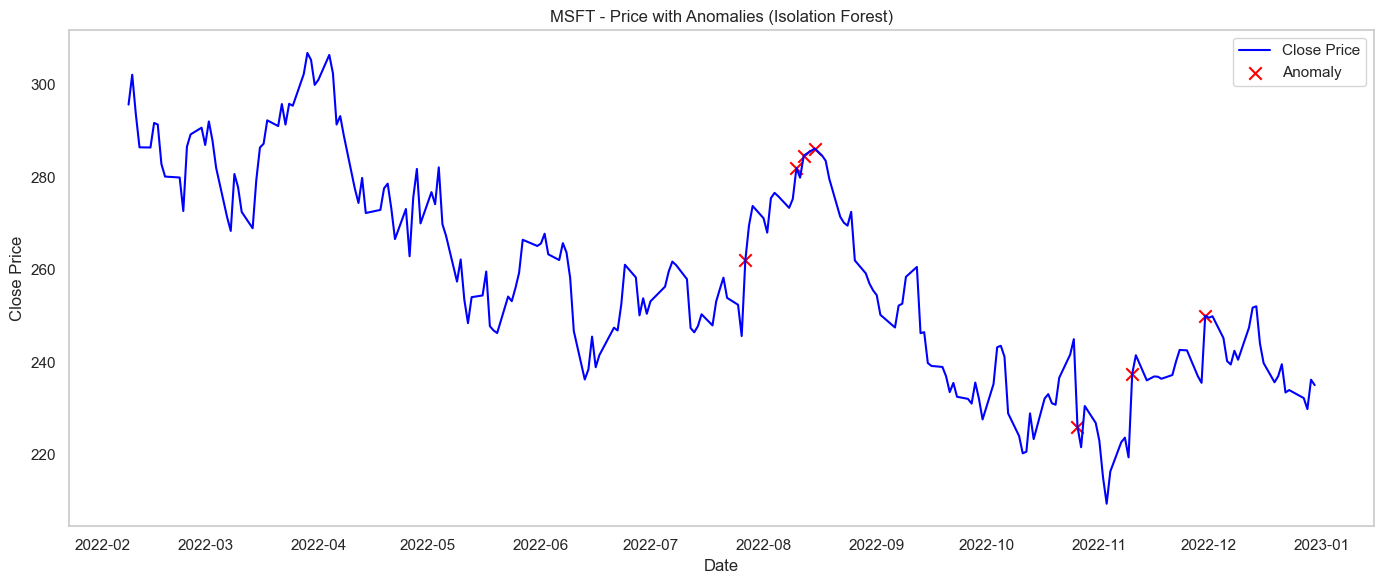

📊 Chart saved as anomaly_chart.png
✅ Data saved to MSFT_anomaly_detected.csv


In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from ta.momentum import RSIIndicator
from ta.trend import MACD

# Step 1: Load Data
def load_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df.dropna(inplace=True)

    # Compute daily returns
    df['Return'] = df['Close'].pct_change()

    # Ensure 'Close' is a Series, not DataFrame
    close = df['Close']
    if isinstance(close, pd.DataFrame):
        close = close.squeeze()

    # Technical Indicators (RSI and MACD)
    rsi = RSIIndicator(close=close)
    macd = MACD(close=close)

    df['RSI'] = rsi.rsi()
    df['MACD'] = macd.macd()

    df.dropna(inplace=True)
    return df

# Step 2: Train Isolation Forest
def train_model(df):
    features = df[['Return', 'RSI', 'MACD']].copy()
    features.fillna(0, inplace=True)

    model = IsolationForest(contamination=0.03, random_state=42)
    df['Anomaly'] = model.fit_predict(features)
    df['Anomaly'] = df['Anomaly'].map({1: 0, -1: 1})
    
    return model, df

# Step 3: Visualize Anomalies
def visualize(df, ticker):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    plt.scatter(df[df['Anomaly'] == 1].index, df[df['Anomaly'] == 1]['Close'],
                color='red', label='Anomaly', marker='x', s=80)
    plt.title(f"{ticker} - Price with Anomalies (Isolation Forest)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig("anomaly_chart.png")
    plt.show()
    print("📊 Chart saved as anomaly_chart.png")

# Step 4: Run
if __name__ == "__main__":
    ticker = "MSFT"  # Try 'AAPL', 'TSLA', or 'INFY.NS'
    df = load_data(ticker, "2022-01-01", "2023-01-01")
    model, df = train_model(df)
    visualize(df, ticker)

    df.to_csv(f"{ticker}_anomaly_detected.csv")
    print(f"✅ Data saved to {ticker}_anomaly_detected.csv")